Results
Mean Absolute Error:  0.1099 °C
R² Score:             0.998903


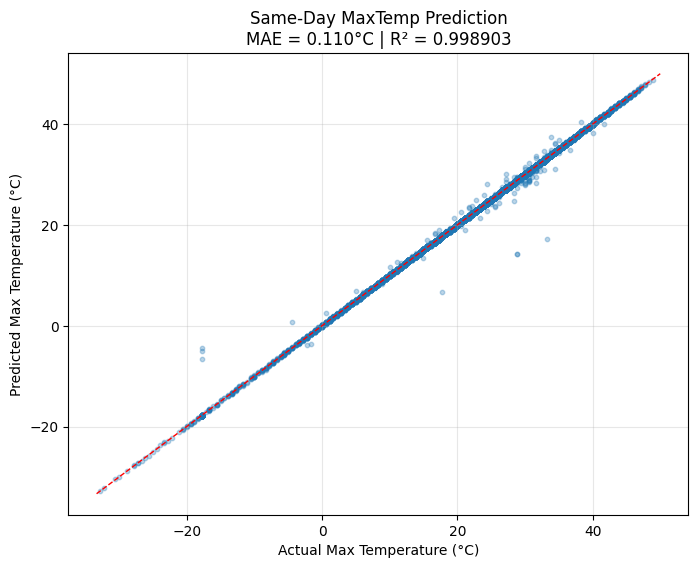

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Features and target
features = ['MinTemp', 'MeanTemp', 'MAX', 'MIN', 'MEA', 'PRCP', 'Month']
X = data[features]
y = data['MaxTemp']

# Fill the missing values in °F columns with their °C counterparts
X = X.copy()
X['MAX'] = X['MAX'].fillna((X['MinTemp']*1.8)+32)
X['MIN'] = X['MIN'].fillna((X['MinTemp']*1.8)+32)
X['MEA'] = X['MEA'].fillna((X['MeanTemp']*1.8)+32)
X['PRCP'] = X['PRCP'].fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Results")
print(f"Mean Absolute Error:  {mae:.4f} °C")
print(f"R² Score:             {r2:.6f}")

# Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=1)
plt.xlabel("Actual Max Temperature (°C)")
plt.ylabel("Predicted Max Temperature (°C)")
plt.title(f"Same-Day MaxTemp Prediction\nMAE = {mae:.3f}°C | R² = {r2:.6f}")
plt.grid(True, alpha=0.3)
plt.show()